# <Center> HW 5: Classification </center>

In this assignment, we use classification to identify deceptive comments. This assignment needs the following two data files:
- hw5_train.csv: dataset for training
- hw5_test.csv: dataset for testing
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  when i first checked the hotel's website and r...|
|1|  I had really high hopes for this hotel. The lo...|
|0|  My experiences at the Fairmont Chicago were le...|
|...|...|


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
# add your import

In [2]:
train = pd.read_csv("hw5_train.csv")
train.head(3)
test = pd.read_csv("hw5_test.csv")
test.head(3)

,label,text
0,1,This is the hotel for the discriminating busin...
1,0,"What a wonderful experience, super great, help..."
2,0,I stayed at the Talbott twice in the last few ...


## Q1 Text Vectorization and Naive Bayes

For classification, the first step is to compute the word TF-IDF weights for each document. A few options can be configured as given below.


Define a function `naive_bayes(train_docs, train_y, test_docs, test_y, binary=False, use_idf=True, stop_words=None, min_df=1, show_plots=False)`, where


- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
- `test_docs`: is a list of documents for test.
- `test_y`: is the ground-truth labels of test documents.
- `binary`: if true, within a document, the term frequency of a word is binarized to 1 if present and 0 otherwise. If False, the regular term frequency is considered. The default is False.
- `use_idf`: if true, inverse document frequency is used to calculate tfidf score. The default is True.
- `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
- `min_df`: only word with document frequency above this threshold can be included. The default is 1.
- `show_plots`: controls whether to show classification report AND plots. The default is False.


This function does the following:
- Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df, use_idf, binary` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
- Train `Multinomial Naive Bayes` model  using the extracted features from `train_docs` and labels from `train_y`.
- Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
- Predict the labels for `test_docs` with trained model.
- If `show_plots` is True,
    - Print the classification report.
    - Plot the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. On the plot, specify xlabel, ylabel on axis, and the scoring metrics (AUC/PRC/Average Precision) on the title.
- Return the `TfidfVectorizer` and the trained Naive Bayes model.
    

Test your function with following cases:
- `stop_words = None, binary = True, use_idf = True, show_plots = True`
- `stop_words = 'english', binary = False, use_idf = False, show_plots = True`

In [3]:
def naive_bayes(train_docs, train_y, test_docs, test_y, \
                binary=False, use_idf=True, \
                stop_words='english', min_df=1, \
                show_plots=True):
    clf, tfidf_vect = None, None
    
    tfidf_vect = TfidfVectorizer(binary=binary, stop_words=stop_words, use_idf=use_idf)
    dtm= tfidf_vect.fit_transform(train_docs)
    clf = MultinomialNB().fit(dtm, train_y)
    dtm_new = tfidf_vect.transform(test_docs)
    predicted = clf.predict(dtm_new)
    if show_plots==True:
        
        classification_report_result=classification_report(test_y,predicted)
        print(classification_report_result)
        predict_p=clf.predict_proba(dtm_new)
        binary_y = np.where(test_y==1,1,0)
        y_pred = predict_p[:,1]
        fpr, tpr, thresholds = roc_curve(binary_y, y_pred,pos_label=1)
        precision, recall, thresholds = precision_recall_curve(binary_y,y_pred, pos_label=1)
        print("AUC: {:.2%}".format(auc(fpr, tpr)),"PRC: {:.2%}".format(auc(recall, precision)))
        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title('AUC');
        plt.show()
    
        
        
        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('PRC');
        plt.show()
    
    
    
    
    

    
    
    return clf, tfidf_vect

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       233
           1       0.83      0.92      0.87       247

    accuracy                           0.86       480
   macro avg       0.87      0.86      0.86       480
weighted avg       0.87      0.86      0.86       480

AUC: 94.64% PRC: 95.56%


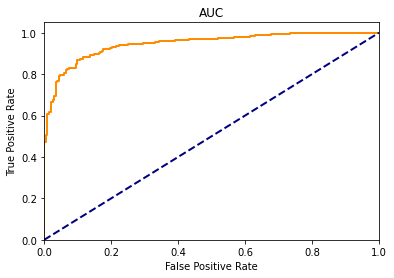

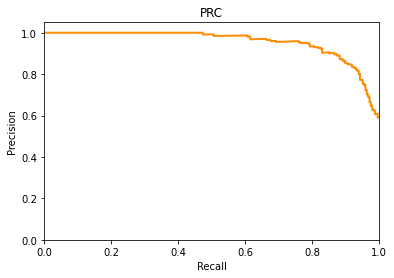

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       233
           1       0.86      0.88      0.87       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480

AUC: 94.32% PRC: 94.90%


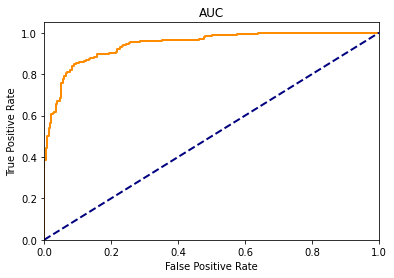

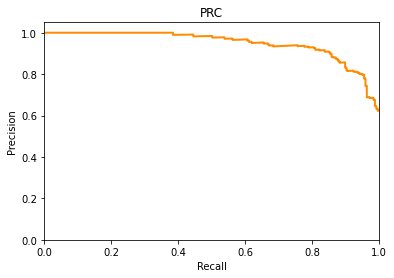

In [4]:
clf, vectorizer = naive_bayes(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words=None, binary=True,
                              use_idf=True, show_plots=True)

lf, vectorizer = naive_bayes(train["text"], train["label"],
                             test["text"], test["label"],
                             stop_words='english', binary=False,
                             use_idf=False, show_plots=True)

### Q2: Search for best parameters 

From Q1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters.

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier.
    - Define the parameter ranges as follow:
        - `stop_words: [None, 'english']`
        - `min_df:[1, 3]`
        - `use_idf:[True, False]`
        - `binary: [True, False]`
    - Set the scoring metric to `f1_macro`.
    - Use `GridSearchCV` with `4-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the values of the `best` parameters combination.
    
- Call the function `naive_bayes` defined in Q1 `with the best parameters combination`. 


Please briefly answer the following:
- Compared with the model in Q1, how is the performance improved on the test dataset?
- Why do you think the new parameter values help deceptive comment classification?

In [5]:
def search_para(docs, y):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf',MultinomialNB())])
    parameters = {  'tfidf__binary': [True, False],
              'tfidf__min_df':[1,3], 
              'tfidf__stop_words':[None,"english"],
              'tfidf__use_idf':[True, False],}
    metric =  "f1_macro"
    gs_clf = GridSearchCV(text_clf, param_grid=parameters,scoring=metric, cv=4)
    gs_clf = gs_clf.fit(docs, y)
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,gs_clf.best_params_[param_name]))

    print("best f1 score: {:.3f}".format(gs_clf.best_score_))

    # add your code

In [6]:
search_para(train["text"], train["label"])

tfidf__binary:	True
tfidf__min_df:	3
tfidf__stop_words:	english
tfidf__use_idf:	False
best f1 score: 0.875


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       233
           1       0.88      0.89      0.88       247

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480

AUC: 94.93% PRC: 95.77%


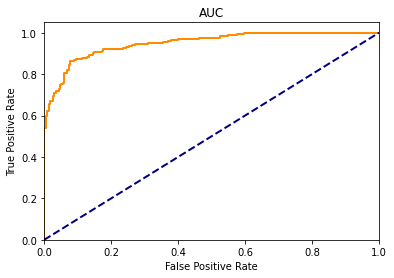

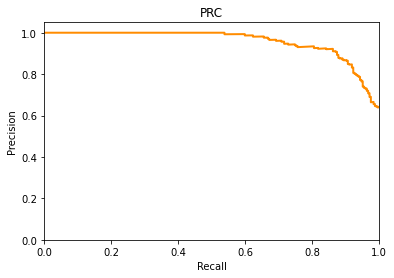

In [7]:
clf, vectorizer = naive_bayes(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words='english', min_df=3, binary=True,
                              use_idf=False, show_plots=True)

In [ ]:
#We can see that all the value in the output of Q2 is higher than in Q1. For the value of AUC PRC and f1 score all of them means the classifier of Q2 is better than in Q1. The precision value in Q2 is higher means with this classifier the proportion of predicted positive examples are real positive examples is higher. The higher recall means more positive samples in dataset are recognized.
#min_df
#When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. When we set it to 3 it ignores the word whose frequency is lower than three it reduces the amount of database.
#tfidf__binary:	True
#It make all the non-zero term counts are set to 1. It plays an important role in building the tf_idf.
#use_idf:Flase
#Make idf(t) = 1.
#stop_words:	English
#clean the database.
#I think the parameter values like the stopwords we set in the new model clean the database the min_df reduce those who shows less than three times.
#tfidf__binary and use_idf:Flase increase the accuracy of the model. So I think all these paramenter help the classifier a lot.


## Q3. Impact of Sample Size 

This task is to help you understand the impact of sample size on classifier performance. 

Define a function `show_sample_size_impact(train_docs, train_y)` where:
- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
    
Conduct the experiment as follows:    
- Starting with 100 samples, in each round you build a classifier with 50 more samples. i.e. in round 1, you use samples from 0 to 100, and in round 2, you use samples from 0 to 150, …, until you use all samples. 
- In each round, create a linear SVM model with 4-fold cross validation. Record the average testing F1-macro score.
- Plot a line chart to show the relationship between sample size and the F1-macro score. 
- This function has no return.
    
    
- Write your analysis on the following:
    - How does sample size affect each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
  

In [22]:
def show_sample_size_impact(train_docs, train_y):
    tfidf_vect = TfidfVectorizer() 
    f1=[]
    size=[]
    for i in range(0,21):
        size1=100+50*i
        train_test=train["text"].iloc[0:100+50*i]
        train_label=train["label"].iloc[0:100+50*i]
        dtm= tfidf_vect.fit_transform(train_test)
        metrics = ['precision_macro', 'recall_macro', "f1_macro"]
        clf = svm.LinearSVC()
        cv = cross_validate(clf, dtm, train_label, scoring=metrics, cv=4)
        f1_1=cv['test_f1_macro'].mean()
        f1.append(f1_1)
        size.append(size1)
    plt.plot(size, f1, ls='-', lw=2, label='f1')
    plt.legend()
    plt.xlabel('size')

    plt.show()
    
    
    
    # add your code

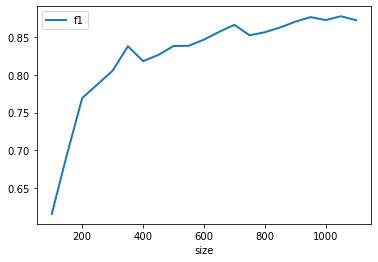

In [23]:
show_sample_size_impact(train["text"], train["label"])

In [ ]:
#We can see that with the increase of the sample size the f1 score become higher. And when the sample size become big enough the score will keep at a high level.
#In most condition I think more sample will come out a better result. But for this question I think we can determine the sample size because when it comes to 1000 the value of f1_ score don’t change. So I think 1000 is enough for the model.


## Q4 (Bonus): Model Interpretation

For this dataset, both Naive Bayes and SVM model can provide good classification accuracy. The question is, how the models conclude that a document is deceptive. What features have the discriminative power?


Let's consider the Naive Bayes model you trained in Q2 with the best parameter values. Two test documents have been provided below. The ground truth of the first document is 0 and the second one is 1. For each document, can you show the following:

1. What are the most discriminative features used by the classifier to produce the prediction? (hint: you can check `model.feature_log_prob_` for Naive Bayes model)
1. Why is the document predicted as positive or negative?
1. Do you think this prediction makes sense? 


You don't need to define any function here. Just write scripts with comments to answer questions 1 & 2. For question 3, describe your analysis and thoughts as comments or in a separate pdf file.

In [11]:
docs = ['''We visited for my 40th birthday. We had never been to Chicago so was not sure where to stay. 
           Found the deal on this hotel from Travelzoo.
           Great rate, staff was awesome, very helpful and nice, location was great. 
           Enjoyed our stay but still like NYC better. Great, great hotel. Would stay again.''',
        '''My experience at the Hyatt Regency Chicago was simply amazing. 
           I had a wonderful stay there will my husband. 
           My husband has allergy problems nearly everywhere we go, and we were worried about that so we talked to the desk clerk there. 
           They were able to provide us with a Hyatt allergy-friendly room. 
           We were so relieved and the room was beautiful. 
           The furniture in the room was actually cleaned with pure tea tree oil. 
           It was the most comfortable stay we have ever had. 
           On top of that my husband had to spend some time in the room working on some business, 
           so the high speed internet they provided was very convenient. 
           We took full advantage of the 24 hour room service. 
           I will definitely stay there again. It is a vacation simply staying in your hotel room.''']

labels = [0, 1]

In [ ]:
# Add your code and analysis

In [41]:
tfidf_vect = TfidfVectorizer(binary=True, stop_words="english", use_idf=False,min_df=3)
dtm= tfidf_vect.fit_transform(train["text"])
clf = MultinomialNB().fit(dtm, train["label"])#build the train model with the best parameter values from Q2.
dtm_new = tfidf_vect.transform(docs)
predicted1 = clf.predict_proba(dtm_new)#From the result we can see that for the first sentences the probability of negative is 0.6596 so 
#it's negative the second sentences the probability of negative is 0.136 so it is positive.
predicted2 = clf.predict(dtm_new)# do the predicction
count = CountVectorizer()
bag_of_words = count.fit_transform(train["text"])
trainword=count.get_feature_names()# find all the features we used in train sample
print(clf.feature_log_prob_)# the probability of the words we used in the train sample.
count1=CountVectorizer()
word_text=count1.fit_transform(docs)
textword=count1.get_feature_names()
index_train=[]
word_train=[]
train_prob=[]
for i in trainword:
    if i in textword:
        index_train.append(trainword.index(i))# get the index of words who is in both train sample and the docs
        word_train.append(i)# get the words who is in both train sample and the docs they are the features  used by the classifier to produce the prediction
#for i in index_train:
    #train_prob.append(clf.feature_log_prob_[1,i])
print(word_train)
print(predicted1)
print(predicted2)


[[-7.61336355 -8.55590986 -7.15380929 ... -8.48102941 -8.5399832
  -8.54865525]
 [-8.06897519 -8.68264346 -7.56230054 ... -8.82306229 -8.43271179
  -8.82306229]]
['24', '40th', 'able', 'about', 'actually', 'advantage', 'again', 'allergy', 'amazing', 'and', 'at', 'awesome', 'beautiful', 'been', 'better', 'birthday', 'business', 'but', 'chicago', 'cleaned', 'clerk', 'comfortable', 'convenient', 'deal', 'definitely', 'desk', 'enjoyed', 'ever', 'everywhere', 'experience', 'for', 'found', 'friendly', 'from', 'full', 'furniture', 'go', 'great', 'had', 'has', 'have', 'helpful', 'high', 'hotel', 'hour', 'husband', 'hyatt', 'in', 'internet', 'is', 'it', 'like', 'location', 'most', 'my', 'nearly', 'never', 'nice', 'not', 'nyc', 'of', 'oil', 'on', 'our', 'problems', 'provide', 'provided', 'pure', 'rate', 'regency', 'relieved', 'room', 'service', 'simply', 'so', 'some', 'speed', 'spend', 'staff', 'stay', 'staying', 'still', 'sure', 'talked', 'tea', 'that', 'the', 'there', 'they', 'this', 'time', '

In [ ]:
# I think this predicrion make sense. From Q3 we can see that our database is big enough for the model to get a good prediction. 
#From the features we can see that most of the words are caontian in the training model so the prediction can be sensable.